In [32]:
import MGTomo.model as mgmodel
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv, mysub
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch_box

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [5,5]

In [3]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 200, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
#c0 = A[0].sumnorm()
c0 = 100
tau0 = 0.5 * 1/c0

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

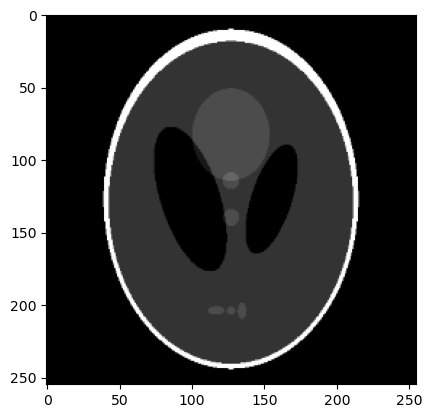

In [7]:
plt.imshow(x_orig, cmap = 'gray')

## Test relative L-smoothness of fh

In [8]:
def Dfhst(s,t):
    fhs = fh(s)
    fht = fh(t)
    fht.backward(retain_graph = True)
    grad_fh_t = t.grad.clone()
    #print(y0.grad)
    Dfhst = fhs - fht - torch.sum(grad_fh_t * (s-t))
    
    return Dfhst

def Klst(s,t):
    st = mydiv(s,t)
    KLst_zw = s* mylog(st) + s - t

    KLst = torch.sum( KLst_zw[t > 0.] ) + 0.5*torch.sum(st[t == 0.]**2)
    
    return KLst

In [9]:
for i in range(5):
    s = torch.rand(N, N, requires_grad = True)
    t = torch.rand(N, N, requires_grad = True)
    
    assert Dfhst(s,t) <= c0 * Klst(s,t)

In [10]:
for i in range(5):
    z0 = torch.rand(N, N, requires_grad = True)
    z1 = fcts.SMART(fh, z0, tau0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

In [11]:
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
for i in range(100):
    val = fcts.SMART(fh, z0, tau0)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
print(fh(z0)/fhz0)

tensor(1.6544e-05, dtype=torch.float64, grad_fn=<DivBackward0>)


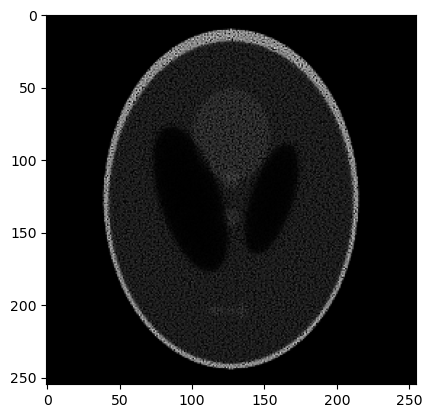

In [12]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

In [13]:
for i in range(5):
    z0 = torch.rand(N, N, requires_grad = True)
    z1 = fcts.BSMART(fh, z0, tau0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

In [14]:
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
for i in range(100):
    val = fcts.BSMART(fh, z0, tau0)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
print(fh(z0)/fhz0)

tensor(5.0086e-05, dtype=torch.float64, grad_fn=<DivBackward0>)


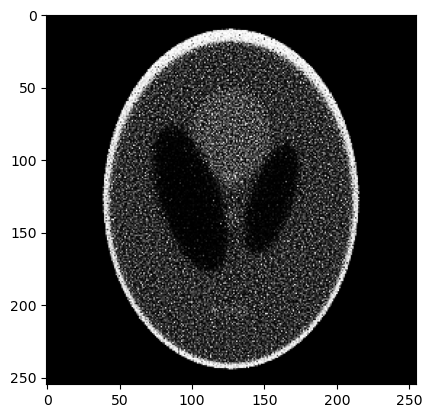

In [15]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

# Setup coarse model

In [16]:
y0 = torch.ones(N, N)*0.5
y0.requires_grad = True

In [17]:
x0 = R(y0)
x0.retain_grad()

x0 = x0.clone().detach().requires_grad_(True)
#print(x0)

fH = lambda x: fcts.kl_distance(x, A[1], b[1])

fhy0 = fh(y0)
fhy0.backward(retain_graph = True)

fHx0 = fH(x0)
fHx0.backward(retain_graph = True)

kappa = R(y0.grad) - x0.grad
y0.grad.zero_()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
def psi(x):
    val = fH(x) + torch.sum(kappa * x)
    return val

## Test coarse model psi and coarse function fH properties

In [19]:
def DfHuv(u,v):
    fHu = fH(u)
    fHv = fH(v)
    fHv.backward(retain_graph = True)
    grad_fH_v = v.grad.clone()
    #print(y0.grad)
    DfHuv = fHu - fHv - torch.sum(grad_fH_v * (u-v))
    return DfHuv

def Dpsiuv(u,v):
    psiu = psi(u)
    psiv = psi(v)
    #print(y0.grad)
    psiv.backward()
    #print(y0.grad)
    Dpsiuv = psiu - psiv - torch.sum(v.grad * (u-v))
    
    return Dpsiuv

In [20]:
#c1 = A[1].sumnorm()
c1 = c0
tau1 = 0.5 * 1/c1

In [21]:
NH = int(np.floor(N/2))

In [22]:
for i in range(100):
    u = torch.rand(NH,NH, requires_grad = True)
    v = torch.rand(NH,NH, requires_grad = True)
    
    Kl = Klst(u,v)

    Dpsi = Dpsiuv(u,v)
    v.grad.zero_()
    DfH = DfHuv(u,v)
    v.grad.zero_()
    
    assert Dpsi - c1*Kl <=0.1, Dpsi - c1*Kl
    assert DfH - c1*Kl <= 0.1, Dpsi - c1*Kl
    
    assert (Dpsi - DfH).abs() <= 0.5, Dpsi - DfH

AssertionError: tensor(1.5039, dtype=torch.float64, grad_fn=<SubBackward0>)

## Test psi and SMART

In [23]:
for i in range(5):
    z0 = torch.rand(NH, NH, requires_grad = True)
    z1 = fcts.SMART(psi, z0, tau1)
    
    assert psi(z1) - psi(z0) <=0, psi(z1) - psi(z0)

In [24]:
z0 = torch.rand(NH, NH, requires_grad = True)
for i in range(5):
    val = fcts.SMART(psi, z0, tau1)
    assert psi(val) - psi(z0) <= 0, psi(val) - psi(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None

## Test psi and BSMART

In [25]:
for i in range(100):
    z0 = torch.rand(NH, NH, requires_grad = True)
    z1 = fcts.BSMART(psi, z0, tau1)
    
    assert psi(z1) - psi(z0) <=0, psi(z1) - psi(z0)

In [26]:
z0 = torch.rand(NH, NH, requires_grad = True)
for i in range(200):
    val = fcts.BSMART(psi, z0, tau1)
    assert psi(val) - psi(z0) <= 0, psi(val) - psi(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None

In [27]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

## MLO with an explicit implementation of psi

In [33]:
def MLO(fh, y, last_pts: list, l=0, kappa = 0.5, verbose = True):
    x = RBox(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
        print(l, ' : coarse correction activated')
        
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = RBox(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        
        for i in range(maxIter[l]):
            x.retain_grad()
            val = fcts.BSMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO(psi, x, last_pts, l+1)
            #print('x', x)
            #print('xlast', xlast)

        assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = PBox(x-x0)
    z, a = armijo_linesearch_box(fh, y0, d, verbose = verbose)
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval = fcts.BSMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    return z, last_pts, a

In [29]:
tau = [tau1, tau1]

In [34]:
a = []
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0)
last_pts = [None]*(max_levels+1)
for i in range(100):
    val, ylast, alpha = MLO(fh, z0, last_pts, verbose = True)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    print(i, ': ', fh(z0))

0  : coarse correction activated
at a =  1.0 f_new is <= and x_new.min() =  tensor(-0.1575, grad_fn=<MinBackward1>) with #<0:  tensor(5475) and x_new.max() =  tensor(1.0139, grad_fn=<MaxBackward1>) with #>1:  tensor(5)
at a =  0.5 f_new is <= and x_new.min() =  tensor(-0.0786, grad_fn=<MinBackward1>) with #<0:  tensor(2724) and x_new.max() =  tensor(1.0058, grad_fn=<MaxBackward1>) with #>1:  tensor(2)
at a =  0.25 f_new is <= and x_new.min() =  tensor(-0.0392, grad_fn=<MinBackward1>) with #<0:  tensor(1351) and x_new.max() =  tensor(1.0024, grad_fn=<MaxBackward1>) with #>1:  tensor(2)
at a =  0.125 f_new is <= and x_new.min() =  tensor(-0.0194, grad_fn=<MinBackward1>) with #<0:  tensor(683) and x_new.max() =  tensor(1.0011, grad_fn=<MaxBackward1>) with #>1:  tensor(1)
at a =  0.0625 f_new is <= and x_new.min() =  tensor(-0.0096, grad_fn=<MinBackward1>) with #<0:  tensor(314) and x_new.max() =  tensor(1.0004, grad_fn=<MaxBackward1>) with #>1:  tensor(1)
at a =  0.03125 f_new is <= and x

KeyboardInterrupt: 

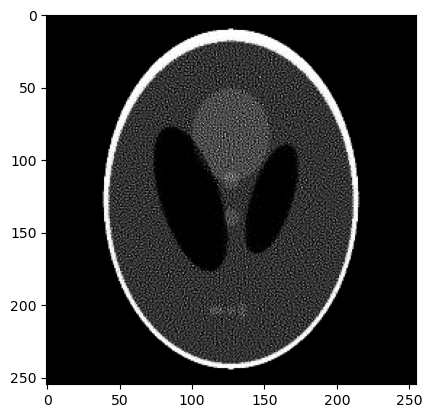

In [31]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')